<a href="https://colab.research.google.com/github/gobeomgyu/deeplearning/blob/main/BP_PPG_ECG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ECG + PPG: SBP/DBP 회귀 (5-Fold, 시간순 분할)
# =================================================
import os, h5py, numpy as np, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

mat_path = "/content/drive/MyDrive/Colab Notebooks/p096530.mat"


In [ ]:
# --- v7.3 로더 ---
def load_mat_v73(filepath):
    f = h5py.File(filepath, "r")
    refs = f["#refs#"]; g = f["Subj_Wins"]
    def get_all(name):
        out=[]; tab=g[name]; n=tab.shape[1]
        for i in range(n):
            ref=tab[0,i]; ds=refs[ref][()]
            out.append(ds)
        return out
    ppg = np.vstack(get_all("PPG_Raw"))
    ecg = np.vstack(get_all("ECG_Raw"))
    sbp = np.array([float(x.squeeze()) for x in get_all("SegSBP")])
    dbp = np.array([float(x.squeeze()) for x in get_all("SegDBP")])
    subj_ascii = get_all("SubjectID")[0].squeeze()
    subject_id = "".join(chr(int(c)) for c in subj_ascii)
    f.close()
    return ppg, ecg, sbp, dbp, subject_id

ppg, ecg, sbp, dbp, subject_id = load_mat_v73(mat_path)
print(f"[INFO] Patient(SubjectID): {subject_id}")
print(f"[INFO] PPG/ECG shape = {ppg.shape}/{ecg.shape}, SBP/DBP shape = {sbp.shape}/{dbp.shape}")


[INFO] Patient(SubjectID): p096530
[INFO] PPG/ECG shape = (2200, 1250)/(2200, 1250), SBP/DBP shape = (2200,)/(2200,)


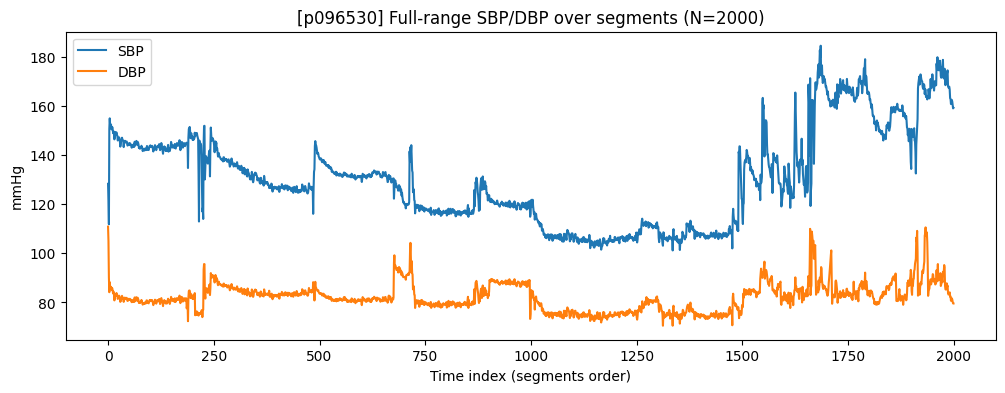

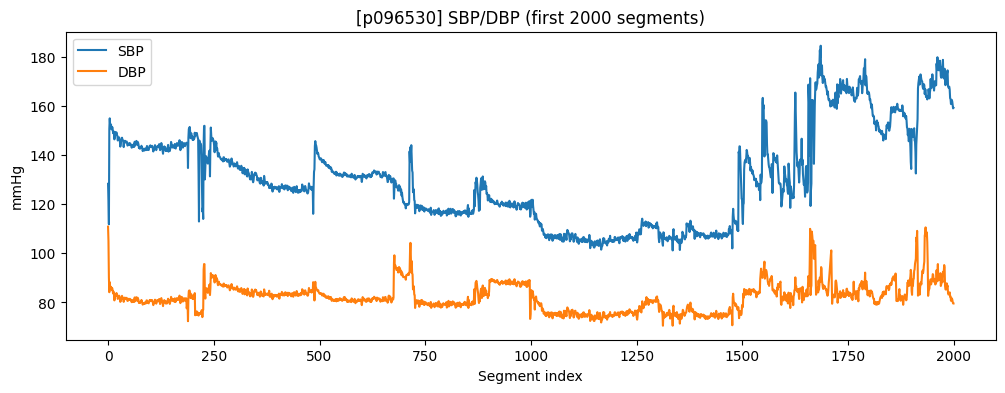

In [ ]:
# --- 2000세그먼트 제한 + 그래프 ---
MAX_SEG=2000
N=min(len(sbp), MAX_SEG)
ppg, ecg, sbp, dbp = ppg[:N], ecg[:N], sbp[:N], dbp[:N]

plt.figure(figsize=(12,4))
plt.plot(sbp, label="SBP")
plt.plot(dbp, label="DBP")
plt.title(f"[{subject_id}] Full-range SBP/DBP over segments (N={N})")
plt.xlabel("Time index (segments order)")
plt.ylabel("mmHg")
plt.legend(); plt.show()

x_idx=np.arange(N)
plt.figure(figsize=(12,4))
plt.plot(x_idx, sbp, label="SBP")
plt.plot(x_idx, dbp, label="DBP")
plt.title(f"[{subject_id}] SBP/DBP (first {N} segments)")
plt.xlabel("Segment index"); plt.ylabel("mmHg")
plt.legend(); plt.show()

# --- 5-Fold 시간 분할 ---
FOLDS=5; SEG_PER_FOLD=N//FOLDS
TRN, VAL, TST = 320, 40, 40
assert SEG_PER_FOLD>=400 and TRN+VAL+TST==SEG_PER_FOLD

# --- 입력(2채널) 구성: (N, L, 2)
X_all = np.stack([ppg, ecg], axis=-1)
y_all = np.stack([sbp, dbp], axis=1)
input_length = X_all.shape[1]; in_ch = X_all.shape[2]

In [ ]:
# --- 모델 ---
def build_model_ecg_ppg(input_len, in_ch):
    inp = layers.Input(shape=(input_len, in_ch))
    x = layers.Conv1D(32, 7, padding="same", activation="relu")(inp)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(64, 5, padding="same", activation="relu")(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(64, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=False))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation="relu")(x)
    out = layers.Dense(2, activation="linear")(x)  # [SBP, DBP]
    model = keras.Model(inp, out)
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="mae",
        metrics=[keras.metrics.MAE]
    )
    return model

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 423ms/step


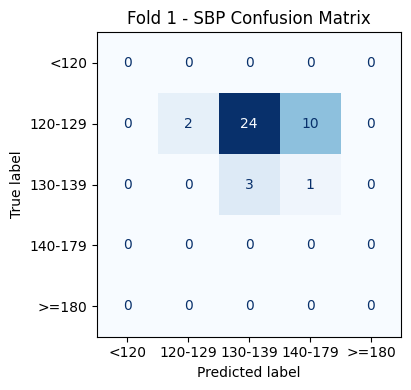

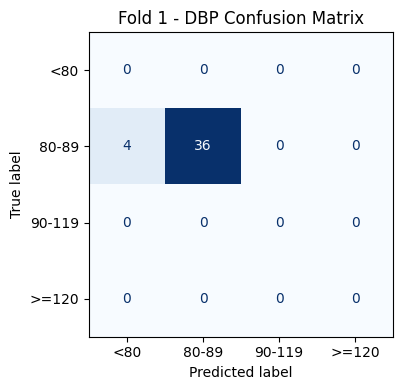

[Fold 1] MAE - SBP: 10.357, DBP: 2.472  |  RMSE - SBP: 114.623, DBP: 8.906
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 410ms/step


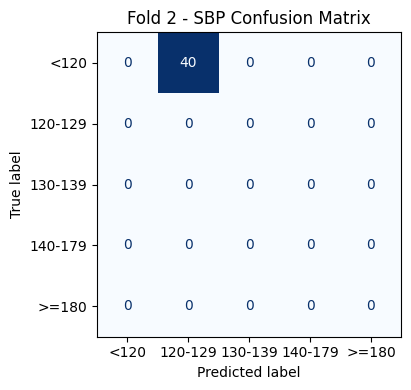

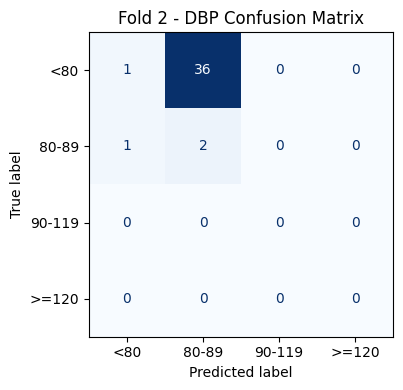

[Fold 2] MAE - SBP: 8.300, DBP: 1.329  |  RMSE - SBP: 69.484, DBP: 2.152


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 437ms/step


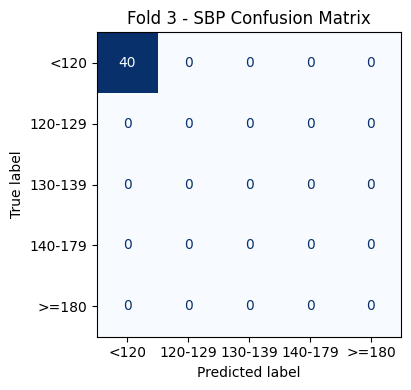

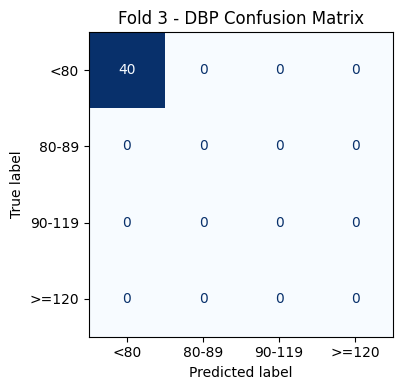

[Fold 3] MAE - SBP: 4.712, DBP: 3.913  |  RMSE - SBP: 44.025, DBP: 25.346
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 446ms/step


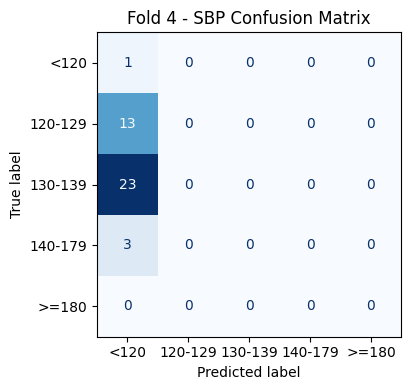

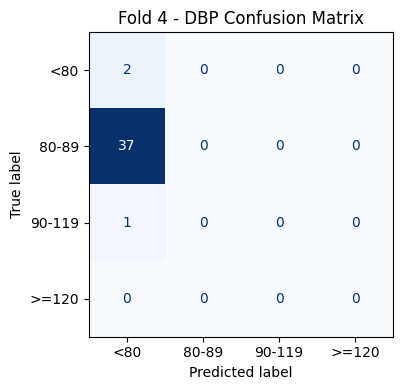

[Fold 4] MAE - SBP: 23.588, DBP: 8.736  |  RMSE - SBP: 591.219, DBP: 85.277
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 425ms/step


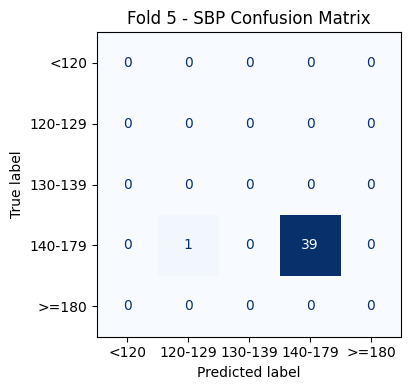

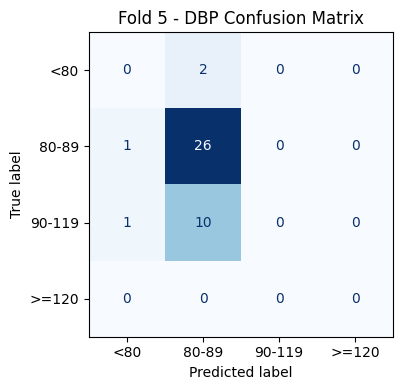

[Fold 5] MAE - SBP: 13.886, DBP: 4.724  |  RMSE - SBP: 269.341, DBP: 40.728


In [ ]:
# --- Fold 루프 ---
fold_mae=[]; fold_rmse=[]
fold_mae_sbp, fold_mae_dbp = [], []
fold_rmse_sbp, fold_rmse_dbp = [], []

for k in range(FOLDS):
    start=k*SEG_PER_FOLD; end=start+SEG_PER_FOLD
    X_fold = X_all[start:end]; y_fold=y_all[start:end]

    X_tr, y_tr = X_fold[:TRN], y_fold[:TRN]
    X_va, y_va = X_fold[TRN:TRN+VAL], y_fold[TRN:TRN+VAL]
    X_te, y_te = X_fold[TRN+VAL:TRN+VAL+TST], y_fold[TRN+VAL:TRN+VAL+TST]

    # --- 입력 표준화(훈련통계만)
    scaler_in = StandardScaler()
    X_tr_2d = X_tr.reshape((X_tr.shape[0], -1))
    X_va_2d = X_va.reshape((X_va.shape[0], -1))
    X_te_2d = X_te.reshape((X_te.shape[0], -1))

    X_tr_2d = scaler_in.fit_transform(X_tr_2d)
    X_va_2d = scaler_in.transform(X_va_2d)
    X_te_2d = scaler_in.transform(X_te_2d)

    X_tr = X_tr_2d.reshape(X_tr.shape)
    X_va = X_va_2d.reshape(X_va.shape)
    X_te = X_te_2d.reshape(X_te.shape)

    # --- 모델/학습
    model = build_model_ecg_ppg(input_length, in_ch)
    cb = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",   # 손실은 항상 낮을수록 좋음
        mode="min",
        patience=7,
        restore_best_weights=True
    )
  ]
    hist = model.fit(
    X_tr, y_tr,
    validation_data=(X_va, y_va),
    epochs=40, batch_size=32,
    callbacks=cb, verbose=0
    )

    # --- 평가
    y_pred = model.predict(X_te, verbose=1)

    # --- 혼동행렬용 누적 저장 (전체 fold 통합)
    all_true_sbp_cls, all_pred_sbp_cls = [], []
    all_true_dbp_cls, all_pred_dbp_cls = [], []

    mae_sbp = mean_absolute_error(y_te[:,0], y_pred[:,0])
    mae_dbp = mean_absolute_error(y_te[:,1], y_pred[:,1])
    rmse_sbp = mean_squared_error(y_te[:,0], y_pred[:,0], )
    rmse_dbp = mean_squared_error(y_te[:,1], y_pred[:,1], )

    # --- 회귀 → 클래스화 (테스트 세트만)
    true_sbp_cls = sbp_to_class(y_te[:, 0])
    pred_sbp_cls = sbp_to_class(y_pred[:, 0])

    true_dbp_cls = dbp_to_class(y_te[:, 1])
    pred_dbp_cls = dbp_to_class(y_pred[:, 1])

    # --- fold별 혼동행렬 플롯
    _ = plot_confmat(true_sbp_cls, pred_sbp_cls, SBP_NAMES, title=f"Fold {k+1} - SBP Confusion Matrix")
    _ = plot_confmat(true_dbp_cls, pred_dbp_cls, DBP_NAMES, title=f"Fold {k+1} - DBP Confusion Matrix")

    # --- 누적 저장 (전체 혼동행렬용)
    all_true_sbp_cls.append(true_sbp_cls); all_pred_sbp_cls.append(pred_sbp_cls)
    all_true_dbp_cls.append(true_dbp_cls); all_pred_dbp_cls.append(pred_dbp_cls)


    fold_mae_sbp.append(mae_sbp); fold_mae_dbp.append(mae_dbp)
    fold_rmse_sbp.append(rmse_sbp); fold_rmse_dbp.append(rmse_dbp)
    fold_mae.append((mae_sbp+mae_dbp)/2); fold_rmse.append((rmse_sbp+rmse_dbp)/2)

    print(f"[Fold {k+1}] MAE - SBP: {mae_sbp:.3f}, DBP: {mae_dbp:.3f}  |  RMSE - SBP: {rmse_sbp:.3f}, DBP: {rmse_dbp:.3f}")


In [ ]:
# --- 종합 결과
def mean_std(a): return float(np.mean(a)), float(np.std(a, ddof=1))
mae_mean, mae_std = mean_std(fold_mae)
rmse_mean, rmse_std = mean_std(fold_rmse)
mae_sbp_mean, mae_sbp_std = mean_std(fold_mae_sbp)
mae_dbp_mean, mae_dbp_std = mean_std(fold_mae_dbp)
rmse_sbp_mean, rmse_sbp_std = mean_std(fold_rmse_sbp)
rmse_dbp_mean, rmse_dbp_std = mean_std(fold_rmse_dbp)

print("\n================= [ECG+PPG Results] =================")
print(f"SubjectID: {subject_id}")
print("Per-fold MAE (avg of SBP/DBP):", [round(x,3) for x in fold_mae])
print("Per-fold RMSE (avg of SBP/DBP):", [round(x,3) for x in fold_rmse])
print(f"Overall MAE:  mean={mae_mean:.3f}  std={mae_std:.3f}")
print(f"Overall RMSE: mean={rmse_mean:.3f}  std={rmse_std:.3f}")
print(f"SBP  MAE  per-fold: {[round(x,3) for x in fold_mae_sbp]}  | mean={mae_sbp_mean:.3f}, std={mae_sbp_std:.3f}")
print(f"DBP  MAE  per-fold: {[round(x,3) for x in fold_mae_dbp]}  | mean={mae_dbp_mean:.3f}, std={mae_dbp_std:.3f}")
print(f"SBP RMSE  per-fold: {[round(x,3) for x in fold_rmse_sbp]} | mean={rmse_sbp_mean:.3f}, std={rmse_sbp_std:.3f}")
print(f"DBP RMSE  per-fold: {[round(x,3) for x in fold_rmse_dbp]} | mean={rmse_dbp_mean:.3f}, std={rmse_dbp_std:.3f}")
print("=====================================================")


================= [ECG+PPG Results] =================
SubjectID: p096530
Per-fold MAE (avg of SBP/DBP): [6.414, 4.814, 4.312, 16.162, 9.305]
Per-fold RMSE (avg of SBP/DBP): [61.765, 35.818, 34.686, 338.248, 155.034]
Overall MAE:  mean=8.202  std=4.857
Overall RMSE: mean=125.110  std=128.924
SBP  MAE  per-fold: [10.357, 8.3, 4.712, 23.588, 13.886]  | mean=12.168, std=7.197
DBP  MAE  per-fold: [2.472, 1.329, 3.913, 8.736, 4.724]  | mean=4.235, std=2.835
SBP RMSE  per-fold: [114.623, 69.484, 44.025, 591.219, 269.341] | mean=217.738, std=226.351
DBP RMSE  per-fold: [8.906, 2.152, 25.346, 85.277, 40.728] | mean=32.482, std=33.098
